In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=0)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:63870 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
from adadamp import DaskBaseDamper

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DaskBaseDamper works with Torch dataset:

In [4]:
class Net(nn.Module):
    def __init__(self, n_features=20, n_outputs=1, hidden=40):
        super(Net, self).__init__()

        self.hidden = hidden
        self.n_features = n_features
        self.n_outputs = n_outputs

        self.fc1 = nn.Linear(self.n_features, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.n_outputs)

    def forward(self, x):
        x = x.float()  # type casting to make sure works well with sklearn
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return y

In [5]:
from sklearn.datasets import make_regression
X, y = make_regression(random_state=42, n_features=20, n_samples=1000, noise=1)
X, y = X.astype("float32"), y.astype("float32")

In [6]:
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)
dataset = torch.utils.data.TensorDataset(X_torch, y_torch)

net = DaskBaseDamper(
    module=Net, loss=nn.MSELoss, optimizer=optim.SGD, optimizer__lr=0.001, batch_size=64,
    cluster=cluster,
)
net.get_params()

{'module': __main__.Net,
 'loss': torch.nn.modules.loss.MSELoss,
 'optimizer': torch.optim.sgd.SGD,
 'metrics': None,
 'device': 'cpu',
 'cluster': LocalCluster('tcp://127.0.0.1:63870', workers=0, threads=0, memory=0 B),
 'example_per_worker': 32,
 'batch_size': 64,
 'max_batch_size': 1024,
 'min_workers': 1,
 'max_workers': 8,
 'optimizer__lr': 0.001}

In [7]:
cluster.workers

{}

In [8]:
import numpy.linalg as LA
data = []
for k in range(10):
    _ = net.fit(dataset);
    score = net.score(X, y)
    norm = sum([LA.norm(x.detach().numpy()) for x in net.module_.parameters()])
    datum = {"score": score, "norm": norm, "n_workers": len(cluster.workers), **net.meta_}
    data.append(datum)

In [9]:
cluster.workers

{0: <Nanny: tcp://127.0.0.1:63875, threads: 8>}

In [10]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,score,norm,n_workers,n_updates,n_data
0,11682.941,36.675925,1,32,1024
1,9511.443,37.840554,1,64,2048
2,9079.734,38.088945,1,96,3072
3,8926.148,38.172250,1,128,4096
4,8855.984,38.206068,1,160,5120


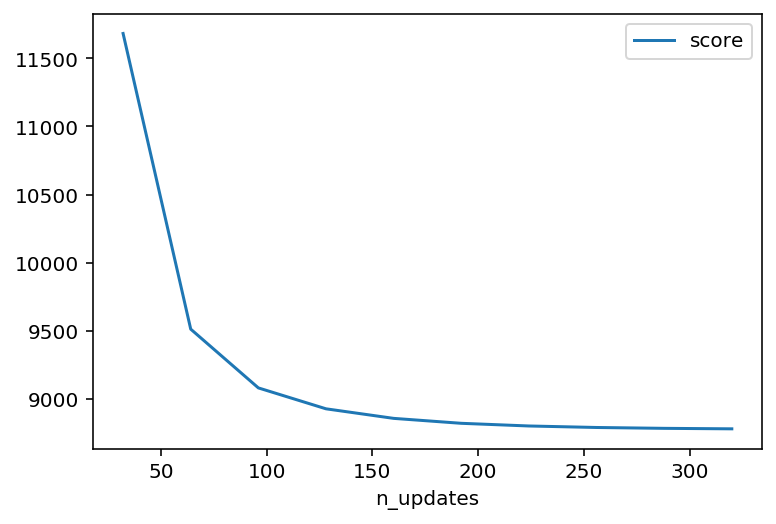

In [11]:
df.plot(x="n_updates", y="score")

In [12]:
net.score(X, y)

8779.102